In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
from scipy.stats.stats import pearsonr
from statsmodels.graphics.gofplots import qqplot

## Import Data
Import 2015 - 2018 Hass Avocado Board (HAB) retail data from one csv from Kaggle (*kag_df*). 
Import twelve csv files from the HAB website covering retail data and global export volume from 2017-2020. Merge retail data into *wkly_rtl_df*, merge comparative retail data by period into *per_df*.

In [2]:
kag_df = pd.read_csv("data/avo-volume-and-price-data.csv")

def create_df(fname, year_start, year_end):
    dfs = []
    for y in range(year_start, year_end+1):
        dfs.append(pd.read_csv(f"data/{y}-{fname}.csv"))
    return pd.concat(dfs)

per_df = create_df('market-region-hab-data',2017,2020)
wkly_rtl_df = create_df('plu-total-hab-data',2017,2020)
vol_df = create_df('volume',2017,2020)

In [3]:
per_df['Current Year Week Ending']

0      2017-01-29 00:00:00
1      2017-02-26 00:00:00
2      2017-03-26 00:00:00
3      2017-04-23 00:00:00
4      2017-05-21 00:00:00
              ...         
103    2020-02-23 00:00:00
104    2020-02-23 00:00:00
105    2020-02-23 00:00:00
106    2020-02-23 00:00:00
107    2020-02-23 00:00:00
Name: Current Year Week Ending, Length: 2268, dtype: object

In [4]:
kag_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
wkly_rtl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17388 entries, 0 to 863
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Geography                  17388 non-null  object 
 1   Timeframe                  17388 non-null  object 
 2   Current Year Week Ending   17388 non-null  object 
 3   Type                       17388 non-null  object 
 4   ASP Current Year           17388 non-null  float64
 5   Total Bulk and Bags Units  17388 non-null  float64
 6   4046 Units                 17388 non-null  float64
 7   4225 Units                 17388 non-null  float64
 8   4770 Units                 17388 non-null  float64
 9   TotalBagged Units          17388 non-null  float64
 10  SmlBagged Units            17388 non-null  float64
 11  LrgBagged Units            17388 non-null  float64
 12  X-LrgBagged Units          17388 non-null  float64
dtypes: float64(9), object(4)
memory usage: 1.9+ MB


In [6]:
vol_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 37
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Week          195 non-null    object
 1   Status        195 non-null    object
 2   Total Volume  195 non-null    object
 3   California    195 non-null    object
 4   Chile         195 non-null    object
 5   Mexico        195 non-null    object
 6   Peru          195 non-null    object
 7   Colombia      195 non-null    object
dtypes: object(8)
memory usage: 13.7+ KB


## Format Columns

Check if ambiguously named 'ASP Current Year' column looks like a YTD average. The value does not converge over the course of each year, so the answer is no.

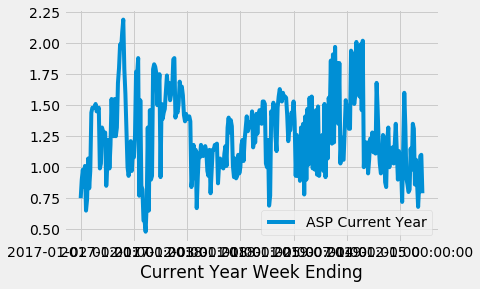

In [7]:
wkly_rtl_df.loc[wkly_rtl_df['Geography']=='Detroit',[
    'Current Year Week Ending', 'ASP Current Year']].plot('Current Year Week Ending');

In [8]:
kag_df['type'].unique()

array(['conventional', 'organic'], dtype=object)

#### Rename Columns
PLU numbers correspond to size. Kaggle data mislabeled bagged avocados as bags of avocados.

In [9]:
kag_df.rename(
    columns={"AveragePrice":'ASP', '4046':'Small', '4225':'Large','4770':'Jumbo',
             'region':'Region', 'type':'Type', 'Total Volume':'Total Units',
             'XLarge Bags':'Jumbo Bagged', 'Total Bags':'Total Bagged', 
             'Small Bags':'Small Bagged'},
    inplace=True)

wkly_rtl_df.rename(
    columns={'Geography':'Region', 'Current Year Week Ending':'Date', 
             'ASP Current Year':'ASP', 'Total Bulk and Bags Units':'Total Units',
             '4046 Units':'Small', '4225 Units':'Large', '4770 Units':'Jumbo',
             'TotalBagged Units':'Total Bagged', 'SmlBagged Units':'Small Bagged', 
             'LrgBagged Units':'Large Bags', 'X-LrgBagged Units':'Jumbo Bagged'},
    inplace=True)

vol_df.rename(
    columns={'Week':'Date'},
    inplace=True)
                   

#### Create Date Columns
Create date columns to make analysis of discrete date intervals easier.

In [10]:
# Create date columns to make analysis of discrete date intervals easier

kag_df['Date'] = pd.to_datetime(kag_df['Date'])
wkly_rtl_df['Date'] = pd.to_datetime(wkly_rtl_df['Date'])
vol_df['Date'] = pd.to_datetime(vol_df['Date'])

def create_datecols(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Weekday'] = df.apply(lambda row: row['Date'].weekday(), axis=1)
    df['Week'] = df.apply(lambda row: row['Date'].isocalendar()[1], axis=1)
    df['Month'] = df.apply(lambda row: row['Date'].month, axis=1)
    df['Day'] = df.apply(lambda row: row['Date'].day, axis=1)
    # df['Timestamp'] = df.apply(lambda row: row['Date'].timestamp(), axis=1)
    df['Year'] = df.apply(lambda row: row['Date'].year, axis=1)
    
    return df.sort_values(by=['Date'])

kag_df = create_datecols(kag_df)
wkly_rtl_df = create_datecols(wkly_rtl_df)
vol_df = create_datecols(vol_df)

#### Format Spaces, Punctuation, and Data Type
Ensure that HAB data and Kaggle data is in the same format. Convert volume data type to float.

In [11]:
wkly_rtl_df[['Region','Type']] = wkly_rtl_df[['Region','Type']].replace(
    '[^A-Za-z0-9]+', '', regex=True)
wkly_rtl_df.drop('Timeframe', axis=1, inplace=True)
kag_df['Type'] = kag_df['Type'].str.capitalize()
kag_df.drop(['Unnamed: 0', 'year'], axis=1, inplace=True)

In [12]:
vol_df[['Total Volume','California','Chile','Mexico','Peru','Colombia']] = vol_df[
    ['Total Volume','California','Chile','Mexico','Peru','Colombia']].apply(lambda x: x.str.replace(',','')).astype('float64')

## Join Retail Tables
Check for unique groups. Hypothesis: Date, Region, Type will be uniques

In [13]:
kag_df.groupby(['Date','Region','Type']).filter(lambda x: len(x) > 1)

,Date,ASP,Total Units,Small,Large,Jumbo,Total Bagged,Small Bagged,Large Bags,Jumbo Bagged,Type,Region,Weekday,Week,Month,Day,Year


kag_df contains only unique groups. Now check wkly_rtl_df.

In [14]:
wkly_rtl_df.groupby(['Date','Region','Type']).filter(lambda x: len(x) > 1)

,Region,Date,Type,ASP,Total Units,Small,Large,Jumbo,Total Bagged,Small Bagged,Large Bags,Jumbo Bagged,Weekday,Week,Month,Day,Year
3293,WestTexNewMexico,2017-02-26,Organic,1.16,39054.83,3021.26,15568.68,11.77,20453.12,20299.52,153.60,0.0,6,8,2,26,2017
3294,WestTexNewMexico,2017-02-26,Organic,1.16,39054.83,3021.26,15568.68,11.77,20453.12,20299.52,153.60,0.0,6,8,2,26,2017
3348,WestTexNewMexico,2017-03-05,Organic,1.23,24969.30,2292.42,4876.69,52.82,17747.37,17114.89,632.48,0.0,6,9,3,5,2017
3349,WestTexNewMexico,2017-03-05,Organic,1.23,24969.30,2292.42,4876.69,52.82,17747.37,17114.89,632.48,0.0,6,9,3,5,2017


Two duplicate rows. kag_df has all 2017 data, so let's just remove 2017 data from wkly_rtl_df. And while we're at it, remove 2018 data from kag_df

In [15]:
wkly_rtl_df = wkly_rtl_df[wkly_rtl_df['Year'] != 2017]
kag_df = kag_df[kag_df['Year'] != 2018]

#### Merge step

In [16]:
total_rtl_df = pd.merge(kag_df, wkly_rtl_df, how='outer').sort_values(
    ['Date', 'Region', 'Type'], axis=0)
total_rtl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28725 entries, 85 to 28642
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          28725 non-null  datetime64[ns]
 1   ASP           28725 non-null  float64       
 2   Total Units   28725 non-null  float64       
 3   Small         28725 non-null  float64       
 4   Large         28725 non-null  float64       
 5   Jumbo         28725 non-null  float64       
 6   Total Bagged  28725 non-null  float64       
 7   Small Bagged  28725 non-null  float64       
 8   Large Bags    28725 non-null  float64       
 9   Jumbo Bagged  28725 non-null  float64       
 10  Type          28725 non-null  object        
 11  Region        28725 non-null  object        
 12  Weekday       28725 non-null  int64         
 13  Week          28725 non-null  int64         
 14  Month         28725 non-null  int64         
 15  Day           28725 non-null  int64

## What proportion of Hass sold are organic?

In [17]:
organic = total_rtl_df.groupby('Type', axis=0).sum()['Total Units']['Organic']
conventional = total_rtl_df.groupby('Type', axis=0).sum()['Total Units']['Conventional']
total = total_rtl_df['Total Units'].sum()

print('Percent Organic: {:.1%}'.format(organic/total))

Percent Organic: 3.1%


In [18]:
#what proportion of Hass sold are organic by region?
organic = total_rtl_df.groupby(['Type', 'Region'], axis=0).sum()['Total Units']['Organic']
conventional = total_rtl_df.groupby(['Type', 'Region'], axis=0).sum()['Total Units']['Organic']
total = total_rtl_df.groupby('Region').sum()['Total Units']

type(total)

for region in total.index:
    print('{} % Organic: {:.1%}'.format(region, organic[region]/total[region]))
org_series = pd.Series(organic/total, total.index);

Albany % Organic: 2.4%
Atlanta % Organic: 2.6%
BaltimoreWashington % Organic: 3.6%
Boise % Organic: 3.2%
Boston % Organic: 3.2%
BuffaloRochester % Organic: 5.5%
California % Organic: 2.8%
Charlotte % Organic: 3.9%
Chicago % Organic: 4.9%
CincinnatiDayton % Organic: 5.7%
Columbus % Organic: 5.1%
DallasFtWorth % Organic: 1.8%
Denver % Organic: 4.2%
Detroit % Organic: 4.5%
GrandRapids % Organic: 3.1%
GreatLakes % Organic: 4.4%
HarrisburgScranton % Organic: 4.1%
HartfordSpringfield % Organic: 3.5%
Houston % Organic: 1.9%
Indianapolis % Organic: 3.4%
Jacksonville % Organic: 1.7%
LasVegas % Organic: 3.1%
LosAngeles % Organic: 2.9%
Louisville % Organic: 3.6%
MiamiFtLauderdale % Organic: 0.8%
Midsouth % Organic: 4.0%
Nashville % Organic: 3.8%
NewOrleansMobile % Organic: 1.4%
NewYork % Organic: 4.3%
Northeast % Organic: 4.1%
NorthernNewEngland % Organic: 3.7%
Orlando % Organic: 1.5%
Philadelphia % Organic: 4.0%
PhoenixTucson % Organic: 1.3%
Pittsburgh % Organic: 6.5%
Plains % Organic: 2.9%
Port

#### Organic Hass Sales by Region Chart

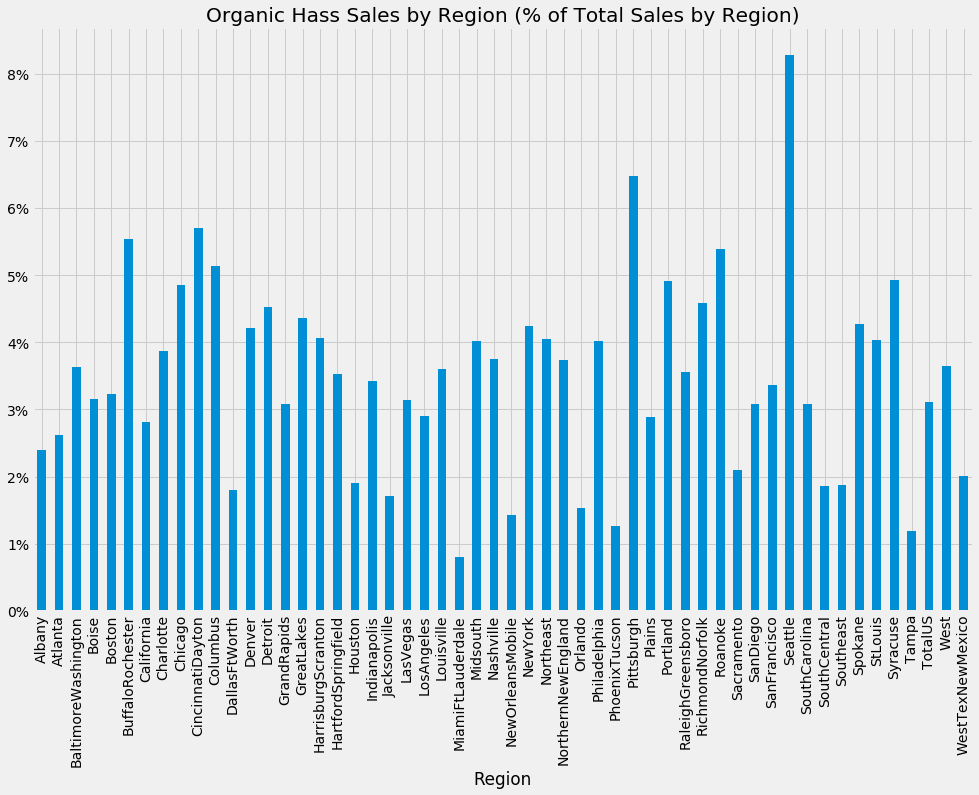

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
org_series.plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_title('Organic Hass Sales by Region (% of Total Sales by Region)')

fig.savefig('images/org_by_region_bar.png')

#### Remove Organic Rows
We are not sure if organic avocado prices rely on the same factors as conventional avocado buyers. Also, our avocado production volume data does not specifiy organic proportion. Given the relatively low organic sales volume across regions, we will focus on conventional sales.

In [20]:
conv_rtl = total_rtl_df.loc[total_rtl_df['Type']=='Conventional',:]

## Split Retail Data by Region
Split retail data into narrow regions, broad regions, and total US.

In [21]:
conv_us_rtl = conv_rtl[conv_rtl['Region'] == 'TotalUS']

conv_broad_reg = conv_rtl[conv_rtl['Region'].isin(
    ['California', 'West', 'Plains','SouthCentral', 'Southeast', 'Midsouth', 'GreatLakes','Northeast'])]

conv_narrow_reg = conv_rtl[np.logical_not(conv_rtl['Region'].isin(
    ['TotalUS','California', 'West', 'Plains','SouthCentral', 'Southeast', 'Midsouth', 'GreatLakes','Northeast']))]

## Merge production volume and retail sales data.
This is an inner join. There is no 2015-2016 production volume data, so the retail data from that period is not merged.

In [22]:
conv_us_vol_rtl = conv_us_rtl.merge(vol_df)
conv_us_vol_rtl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          160 non-null    datetime64[ns]
 1   ASP           160 non-null    float64       
 2   Total Units   160 non-null    float64       
 3   Small         160 non-null    float64       
 4   Large         160 non-null    float64       
 5   Jumbo         160 non-null    float64       
 6   Total Bagged  160 non-null    float64       
 7   Small Bagged  160 non-null    float64       
 8   Large Bags    160 non-null    float64       
 9   Jumbo Bagged  160 non-null    float64       
 10  Type          160 non-null    object        
 11  Region        160 non-null    object        
 12  Weekday       160 non-null    int64         
 13  Week          160 non-null    int64         
 14  Month         160 non-null    int64         
 15  Day           160 non-null    int64     

In [23]:
all_df = pd.merge(total_rtl_df, vol_df)
all_df.groupby(['Date','Region','Type']).filter(lambda x: len(x) > 1)

,Date,ASP,Total Units,Small,Large,Jumbo,Total Bagged,Small Bagged,Large Bags,Jumbo Bagged,...,Month,Day,Year,Status,Total Volume,California,Chile,Mexico,Peru,Colombia


## Plot Avocado Sales, Price, and Production
Mexico produces ~80% of US avocados and California produces ~10%. 

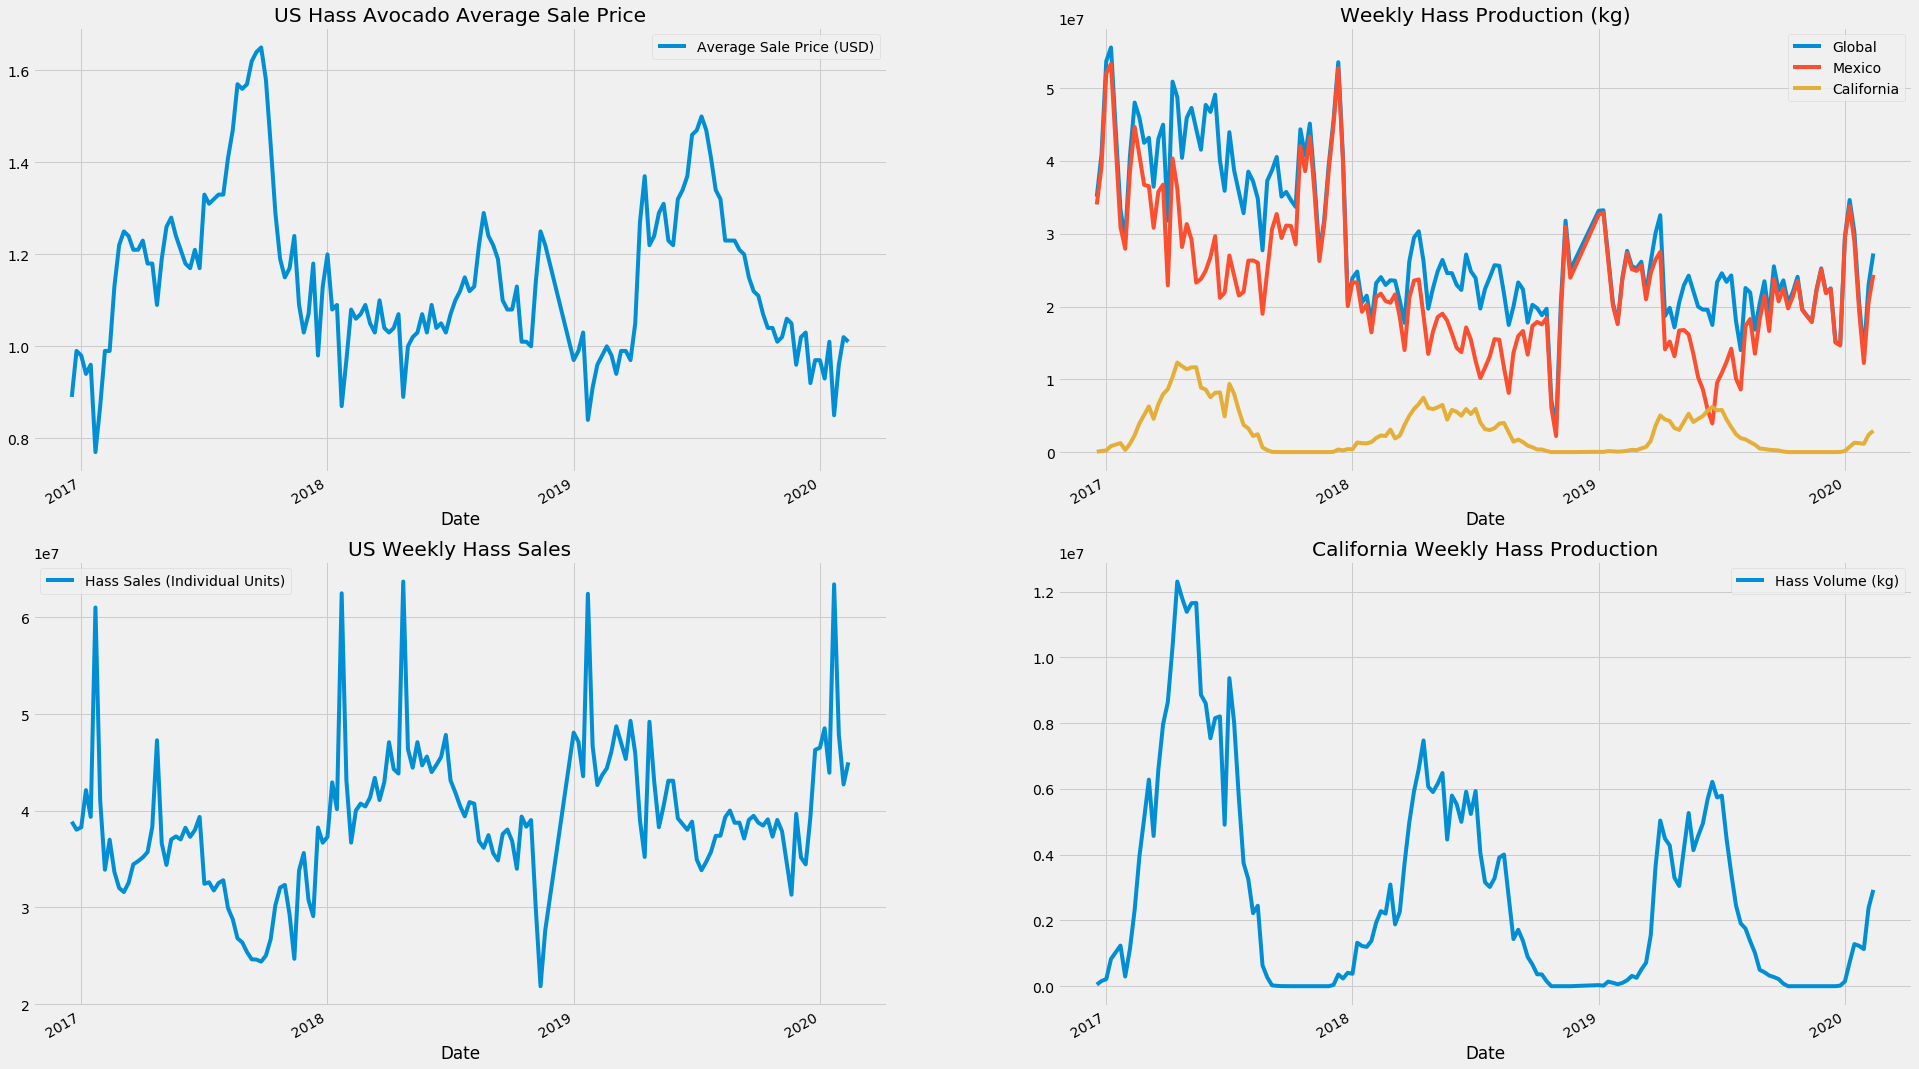

In [44]:
fig, axs = plt.subplots(2,2, figsize = (30,20))
conv_us_vol_rtl.plot('Date','ASP', ax=axs[0,0], label= 'Average Sale Price (USD)', title='US Hass Avocado Average Sale Price')
conv_us_vol_rtl.plot('Date',['Total Volume','Mexico','California'], ax=axs[0,1], label= ['Global','Mexico','California'], title='Weekly Hass Production (kg)')
conv_us_vol_rtl.plot('Date','Total Units', ax=axs[1,0], label= 'Hass Sales (Individual Units)', title='US Weekly Hass Sales')
conv_us_vol_rtl.plot('Date','California', ax=axs[1,1], label= 'Hass Volume (kg)', title='California Weekly Hass Production')
for ax in axs.flatten():
    ax.set_xticks(conv_us_vol_rtl.loc[conv_us_vol_rtl['Week']==2,'Date'])
    ax.set_xticklabels(x.year for x in conv_us_vol_rtl.loc[conv_us_vol_rtl['Week']==3,'Date'])
fig.savefig('images/asp_unitssold_vol.png');

#### Scaled Plots

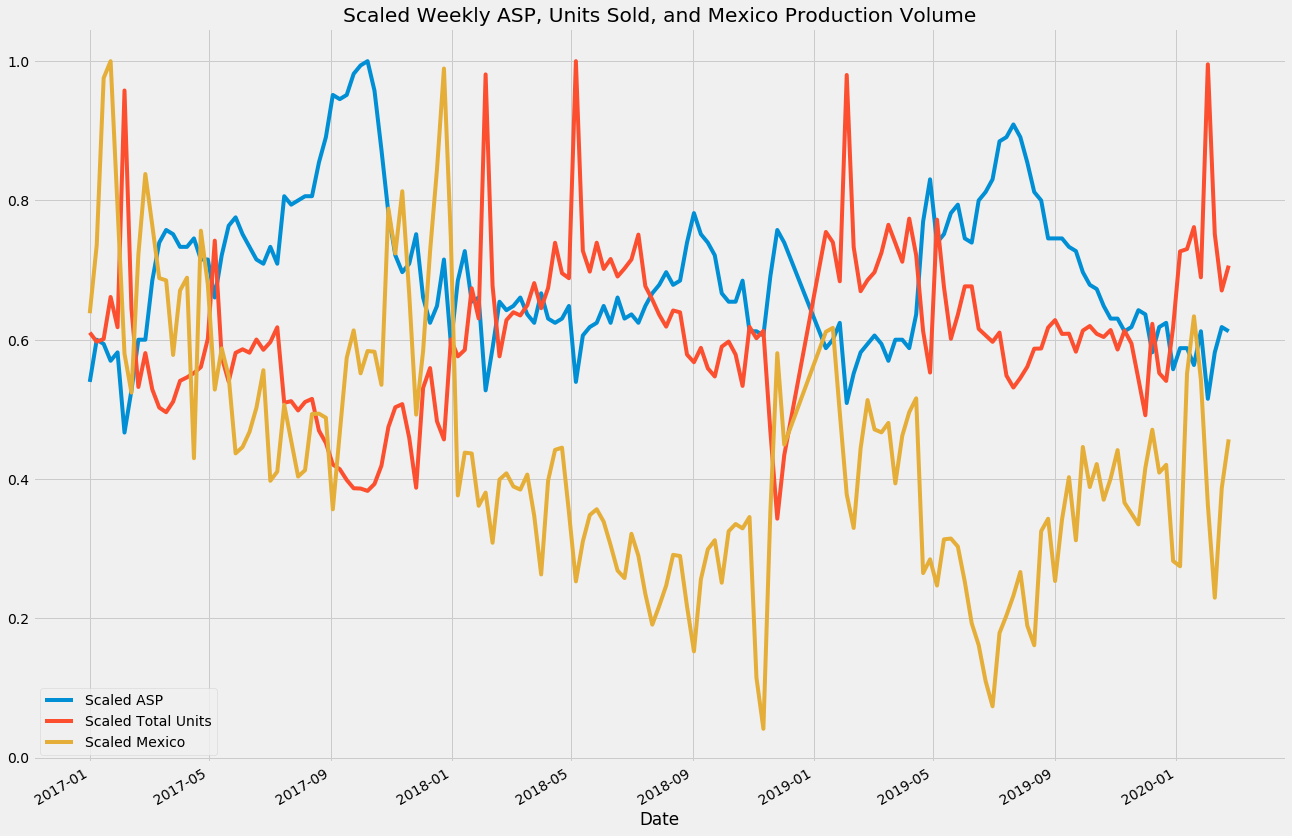

In [33]:
for col in ['ASP', 'Total Units', 'Total Volume', 'Mexico', 'California']:
    conv_us_vol_rtl[f'Scaled {col}'] = conv_us_vol_rtl[col]/conv_us_vol_rtl[col].max()
    
fig, axs = plt.subplots()
    
# conv_us_vol_rtl.plot('Date',['Scaled ASP', 'Scaled Total Units', 'Scaled Total Volume','Scaled Mexico','Scaled California'],
#                      ax=ax, title='Weekly Hass Production (kg)', figsize = (20,15))
conv_us_vol_rtl.plot('Date',['Scaled ASP', 'Scaled Total Units', 'Scaled Mexico'],
                     ax=axs, title='Scaled Weekly ASP, Units Sold, and Mexico Production Volume', figsize = (20,15))
fig.savefig('images/scaled_asp_unitssold_mexicovol.png')

## Pearson Test
Pearson tests can only be performed with normal data. Let's take a look at our data.

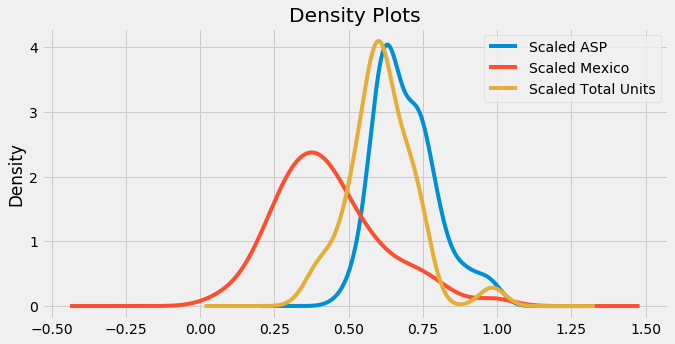

In [26]:
fig, ax = plt.subplots()
conv_us_vol_rtl[['Scaled ASP','Scaled Mexico', 'Scaled Total Units']].plot(
    kind = 'kde', figsize=(10,5), title='Density Plots', ax = ax)
fig.savefig('images/density_plot.png')

Mexico looks the most skewed- let's look at the qqplot.

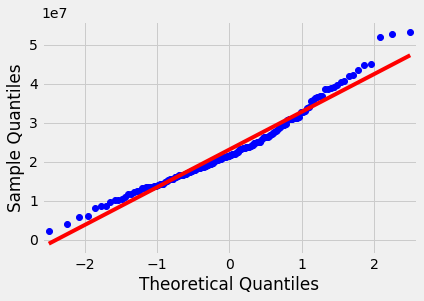

In [34]:
fig = qqplot(conv_us_vol_rtl['Mexico'], line='s')
fig.savefig('images/qqplot_mexico.png')

It looks normal enough to proceed without more analysis.

In [43]:
pearsonr(conv_us_vol_rtl['ASP'], conv_us_vol_rtl['Total Units'])

(-0.7064571359236969, 1.7050654552369544e-25)

In [50]:
pearsonr(conv_us_vol_rtl['ASP'], conv_us_vol_rtl['Mexico'])

(-0.10114422889510502, 0.2031531091247058)

### Feature Exploration

<img src="images/org_by_region.png" />